# Imports

In [1]:
from seaexplorertools import process_adcp
import xarray as xr
import numpy as np
import pandas as pd

# Begin ADCP Data Processing

Set paths to input files and specify options

In [2]:
adcp_path = 'ADCP_refactoring_test_files/sea045_M44.ad2cp.00000*.nc'
glider_pqt_path = 'ADCP_refactoring_test_files/Skag_test.pqt'

options = {
    'debug_plots' : True,
    'correctADCPHeading' : True,
    'ADCP_discardFirstBins' : 0, # First bin often very affected by glider, good to discard, in future we should extend blanking distance
    'ADCP_correlationThreshold': 70, # 70
    'ADCP_amplitudeThreshold' : 75, # 75
    'ADCP_velocityThreshold' : 0.8, # 0.6
    'correctXshear' : False,
    'correctYshear' : False,
    'correctZshear' : False,
    'correctZZshear' : False,
    'ADCP_regrid_correlation_threshold': 20,
    'plots_directory': 'plots',
    }


## Load ADCP data and add necessary glider variables

In [3]:
ADCP, data, options = process_adcp.load_adcp_glider_data(adcp_path, glider_pqt_path, options)

Loaded ADCP_refactoring_test_files/Skag_test.pqt
2023-07-13 12:09:27 : Finished loading ADCP data
2023-07-13 12:09:27 : Added glider variables
2023-07-13 12:09:27 : top mounted: True


In [4]:
data = data[data.profile_number < 199]
ADCP = ADCP.where(ADCP.time < data.time.values[-1]).dropna(dim="time", how="all")


# Start QC Calculate depth of each individual measurement


2023-07-13 12:09:29 : Depth calculation of cells correct. Beam 1 2 4 match on down; 3 2 4 match on up. (Tested on downward facing)


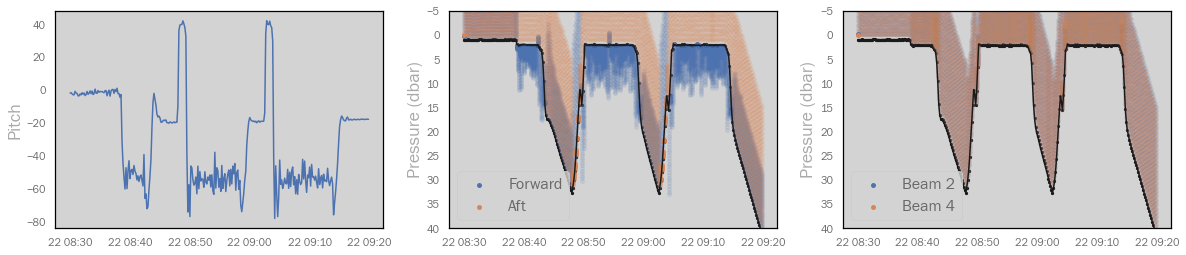

In [5]:
ADCP = process_adcp.remapADCPdepth(ADCP, options)

In [6]:
## ADJUST DISTANCE BASED ON SOUNDSPEED !

## Correct ADCP Heading

        <total-intensity units="nT">51043</total-intensity>

Target = 510.43
Optimization terminated successfully.
         Current function value: 1.707746
         Iterations: 1392
         Function evaluations: 1935
[[ 0.8218908  -0.00215635 -0.0088071 ]
 [-0.00226646  0.86730429 -0.02489248]
 [-0.02411338  0.00473393  0.85283387]]
[ 0.07404023 -0.05074324  0.03226842]
2023-07-13 12:09:43 : Corrected heading and accounted for declination


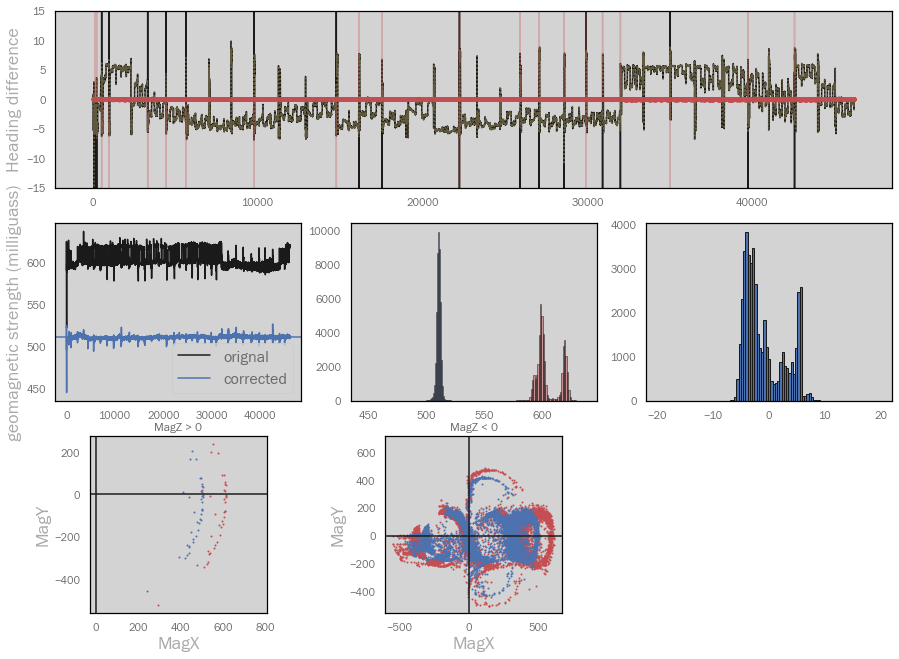

In [7]:
ADCP = process_adcp.correct_heading(ADCP, data, options)

## Perform soundspeed correction

In [8]:
ADCP = process_adcp.soundspeed_correction(ADCP)

2023-07-13 12:09:44 : Corrected beam 1 velocity for sound speed.
2023-07-13 12:09:44 : Corrected beam 2 velocity for sound speed.
2023-07-13 12:09:44 : Corrected beam 3 velocity for sound speed.
2023-07-13 12:09:44 : Corrected beam 4 velocity for sound speed.


## Outlier and poor correlation removal


Now we need to think. What do we discard, what do we keep, do we interpolate across missing bins?

2023-07-13 12:09:47 : Beam 1 correlation: 42.4% removed
2023-07-13 12:09:47 : Beam 1 amplitude: 0.4% removed
2023-07-13 12:09:47 : Beam 1 velocity: 1.4% removed
2023-07-13 12:09:47 : Beam 2 correlation: 42.6% removed
2023-07-13 12:09:47 : Beam 2 amplitude: 0.6% removed
2023-07-13 12:09:47 : Beam 2 velocity: 1.3% removed
2023-07-13 12:09:47 : Beam 3 correlation: 43.6% removed
2023-07-13 12:09:47 : Beam 3 amplitude: 0.6% removed
2023-07-13 12:09:47 : Beam 3 velocity: 1.7% removed
2023-07-13 12:09:47 : Beam 4 correlation: 41.5% removed
2023-07-13 12:09:47 : Beam 4 amplitude: 0.6% removed
2023-07-13 12:09:47 : Beam 4 velocity: 1.2% removed


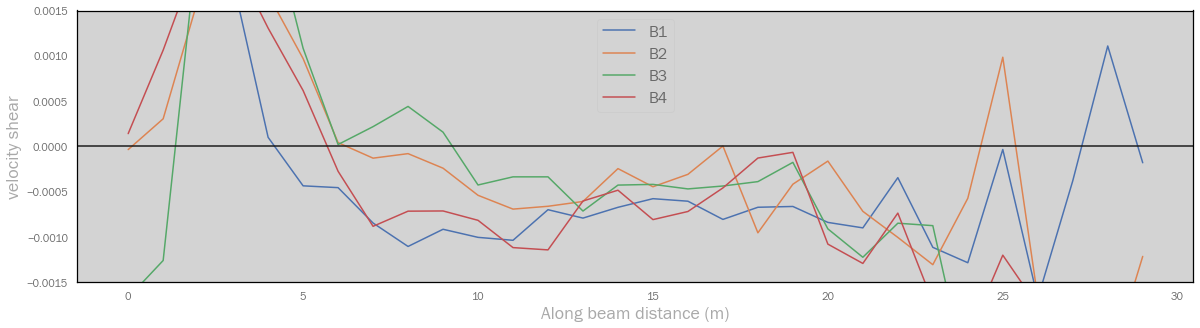

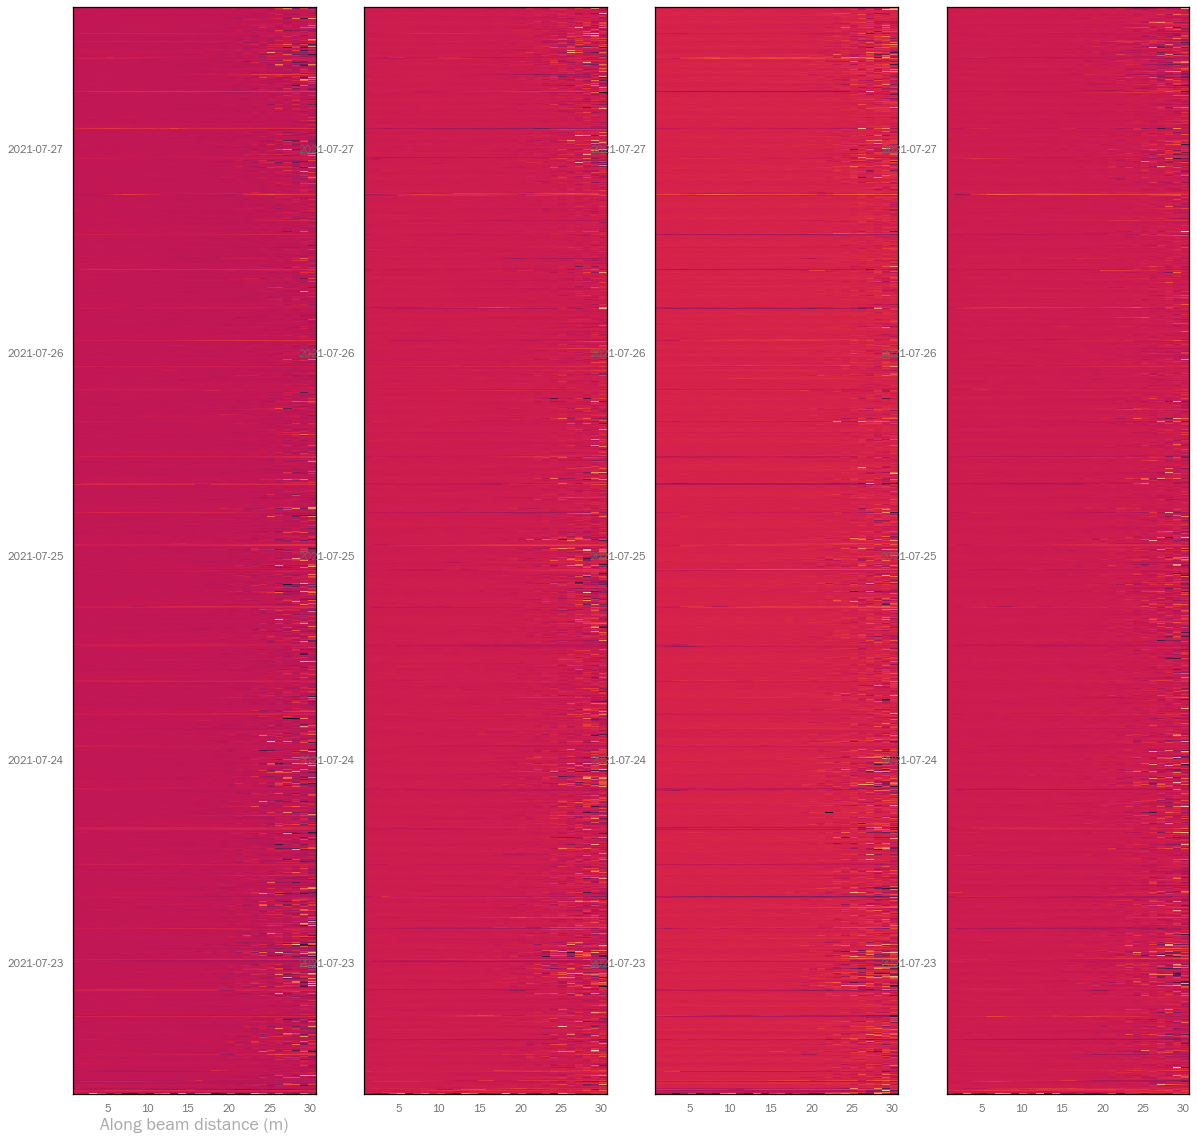

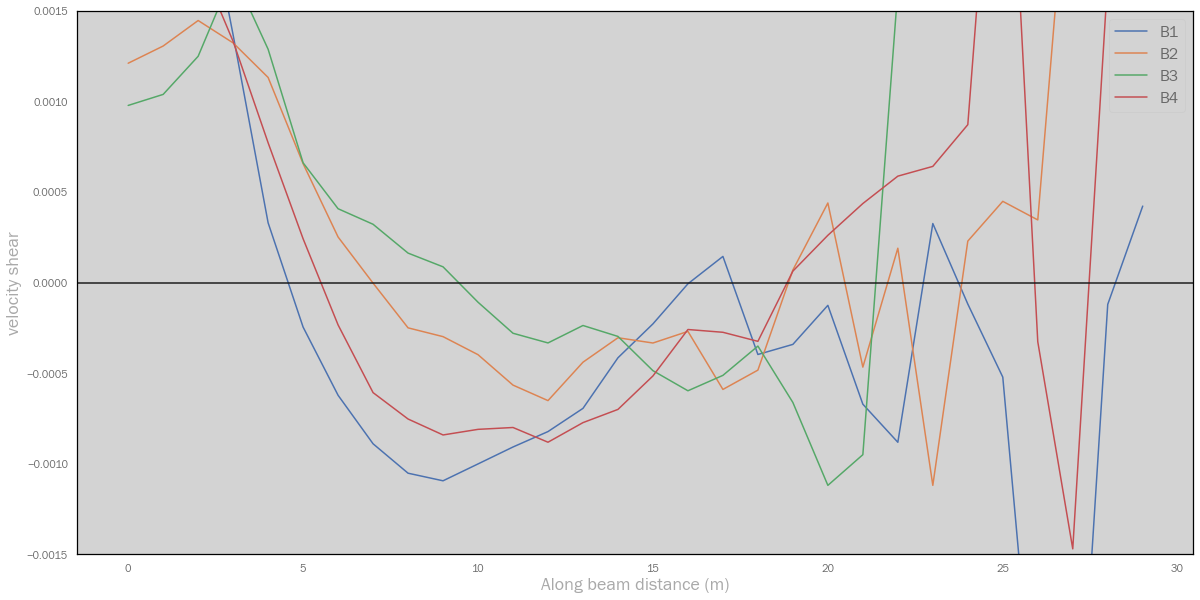

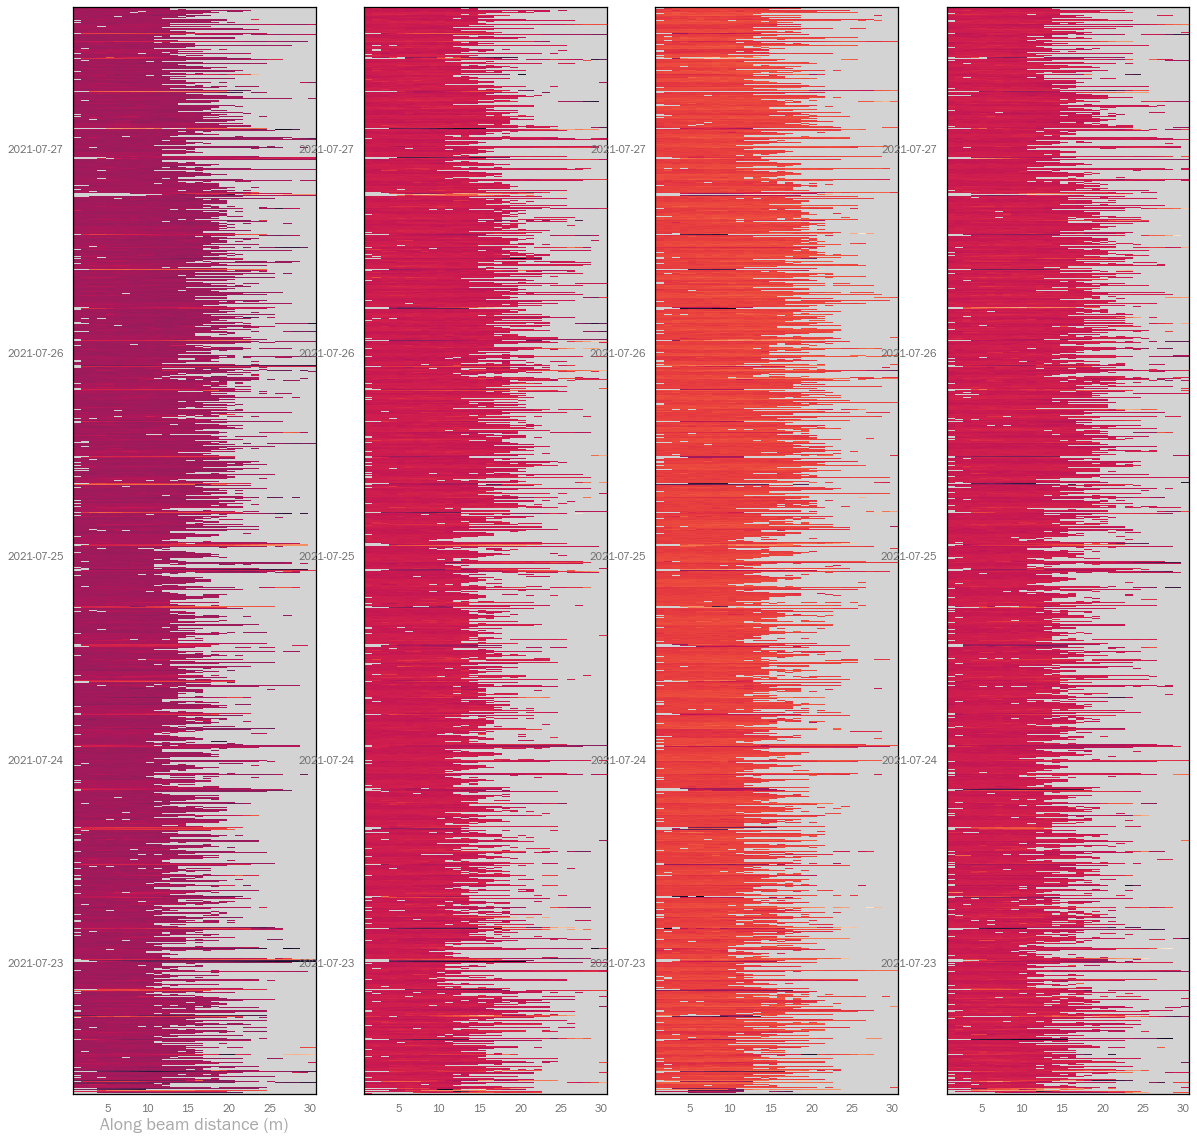

In [9]:
ADCP = process_adcp.remove_outliers(ADCP, options)

Should we interpolate over bad data? Reconstruct missing bins in profiles?

# How many good data per bin?

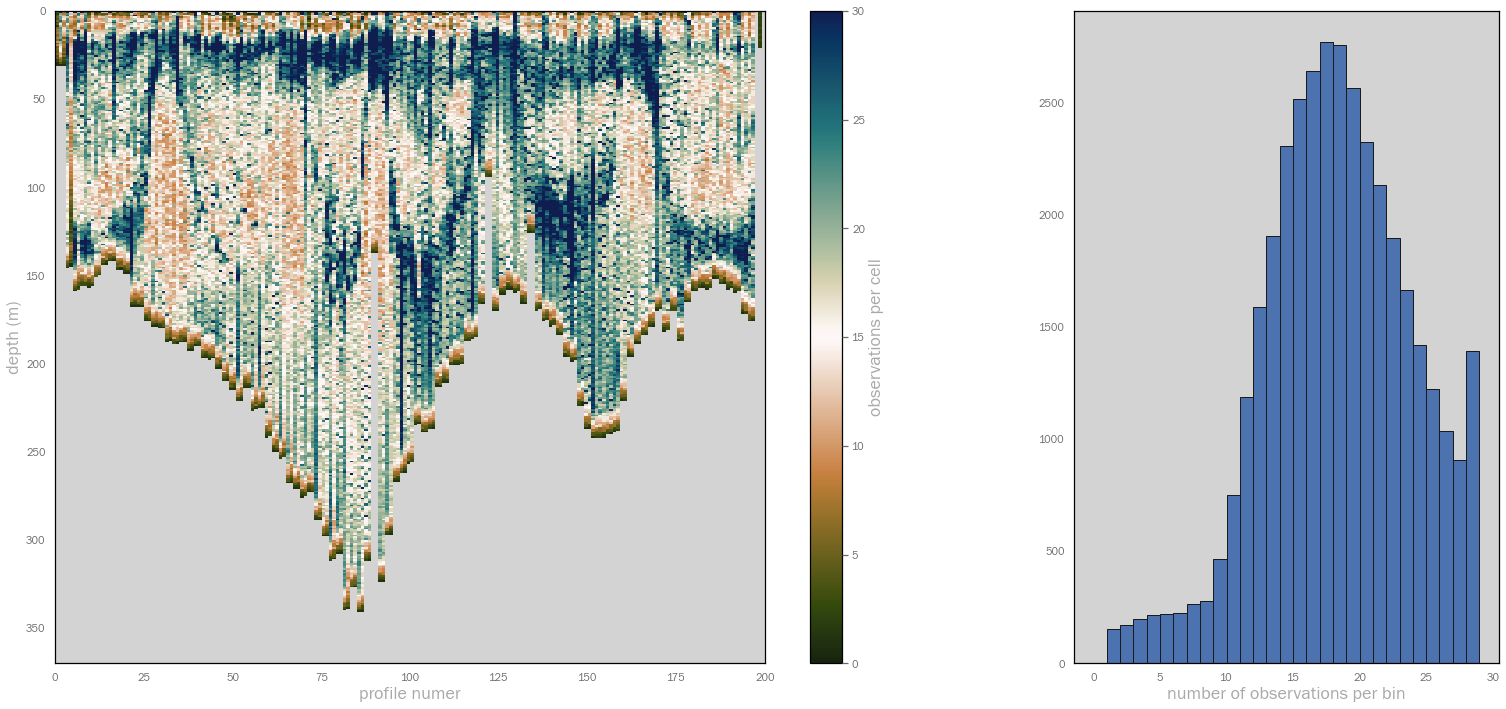

In [10]:
process_adcp.plot_data_density(ADCP, options)

### Correct shear bias

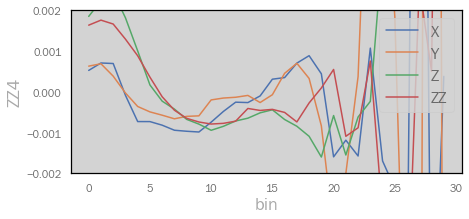

In [11]:
ADCP = process_adcp.correct_shear(ADCP, options)

### Pitching motion correction (TODO - or not TODO)

In [12]:
if options['ADCP_discardFirstBins']: print(ADCP.dims); ADCP = ADCP.isel(bin = ADCP['bin'] >= options['ADCP_discardFirstBins']); print(ADCP.dims); plog('Discarded first '+str(options['ADCP_discardFirstBins'])+' bins from ADCP data')

## 3.4. Correct ADCP acoustic backscatter data (TODO)

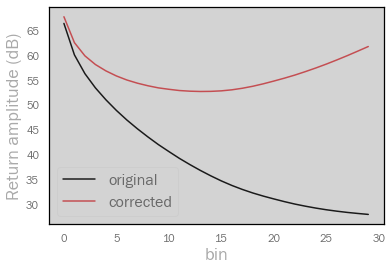

In [13]:
ADCP = process_adcp.correct_backscatter(ADCP, data, options)

## 3.5. Remap 3-beam configuration onto isobars

Using the following depth offsets:
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5]
 
Running gridding on all 4 beams:
2023-07-13 12:10:02 : Calculating beam 1
2023-07-13 12:10:03 : Calculating beam 2
2023-07-13 12:10:05 : Calculating beam 3
2023-07-13 12:10:07 : Calculating beam 4


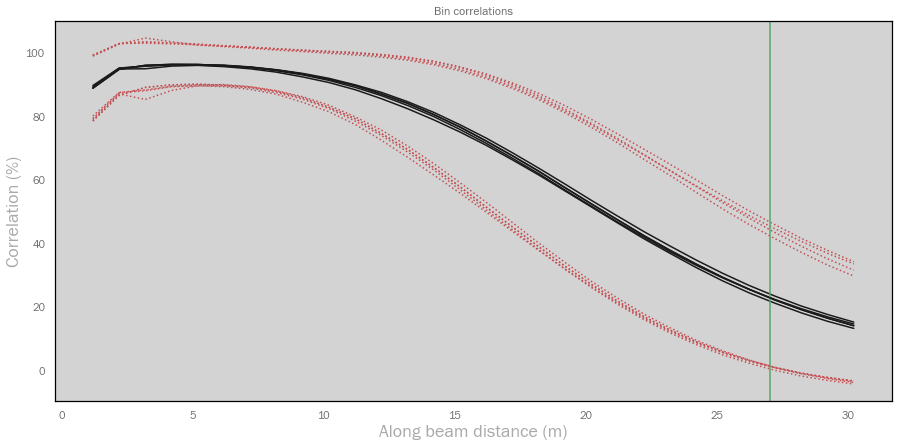

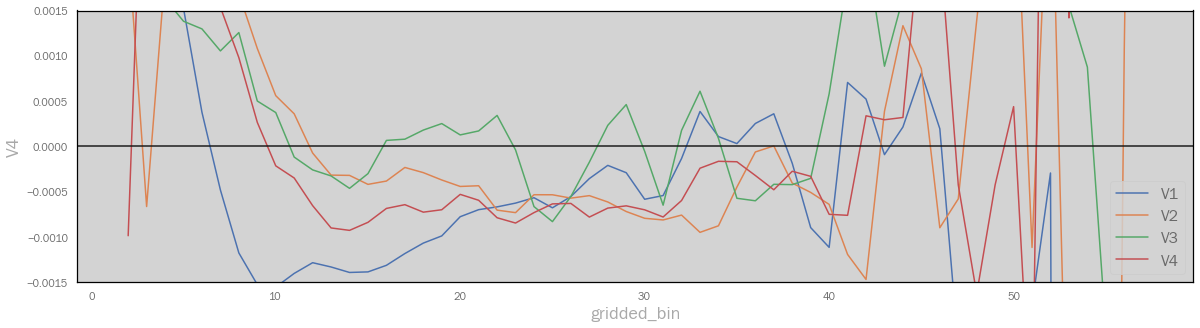

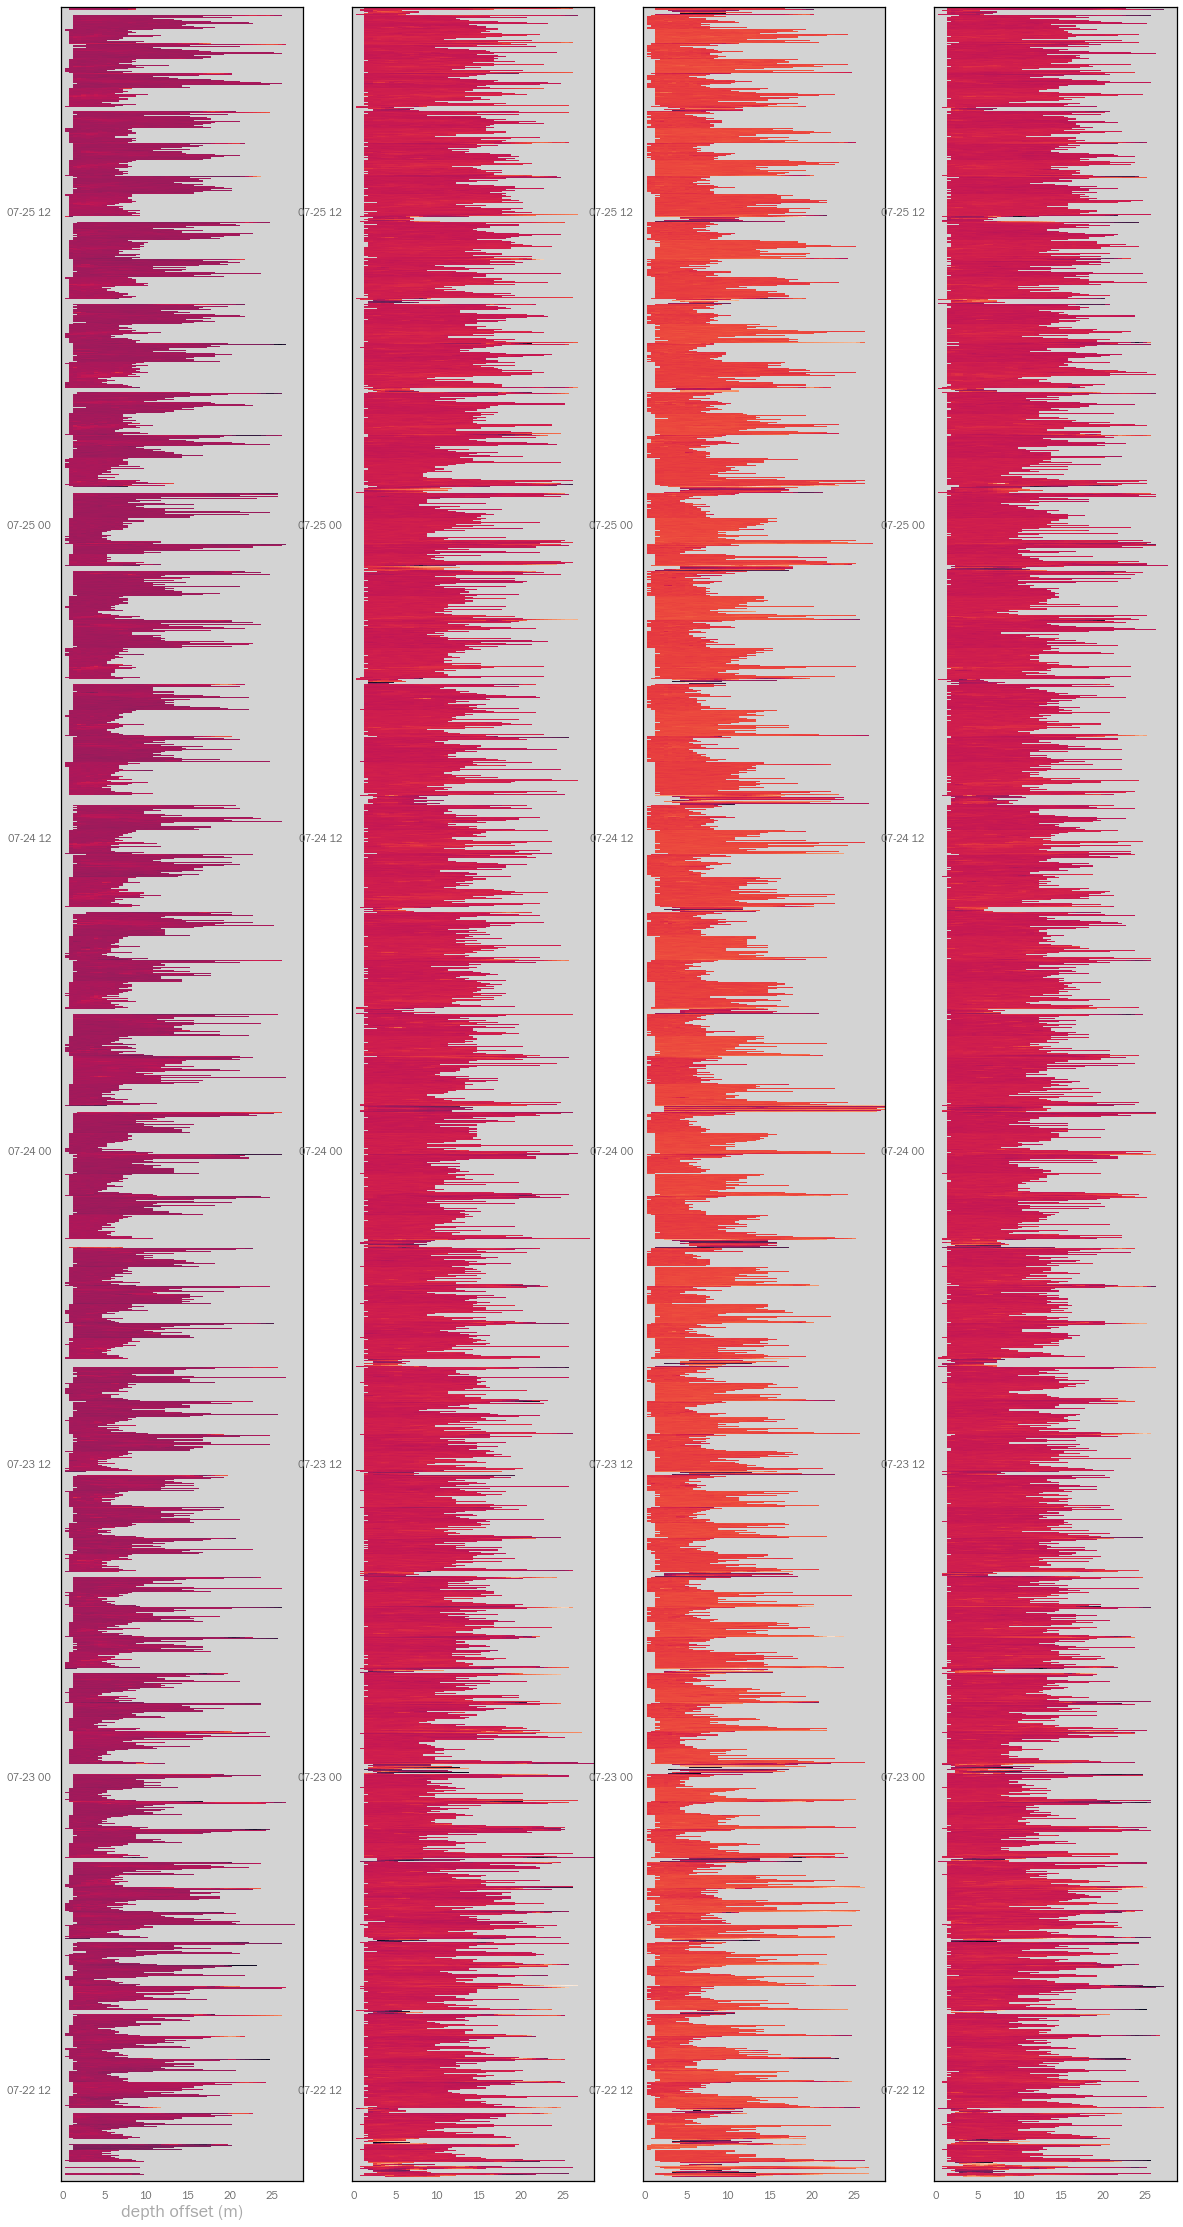

In [14]:
ADCP = process_adcp.regridADCPdata(ADCP, options)

## 3.6. Transform beams to XYZ and ENU velocities

Assuming ADCP is top mounted
2023-07-13 12:10:20 : Calculating X,Y,Z from isobaric 3-beam measurements.


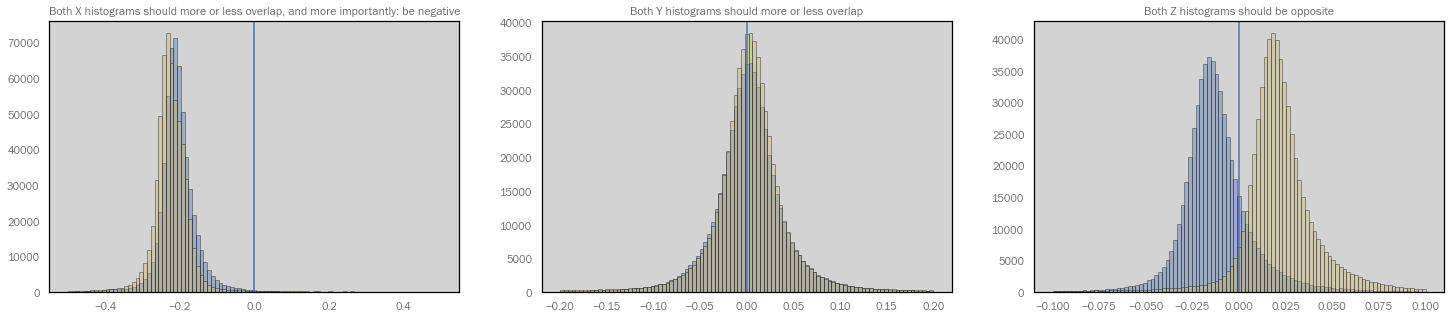

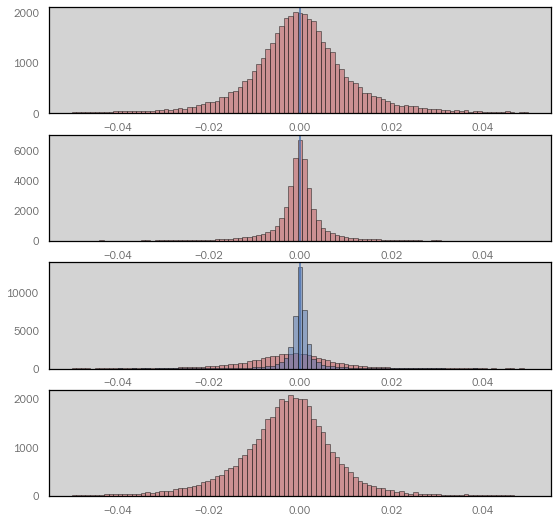

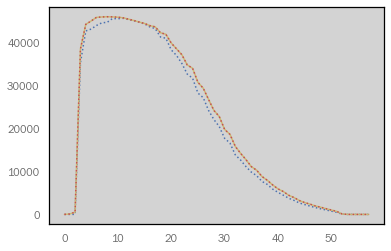

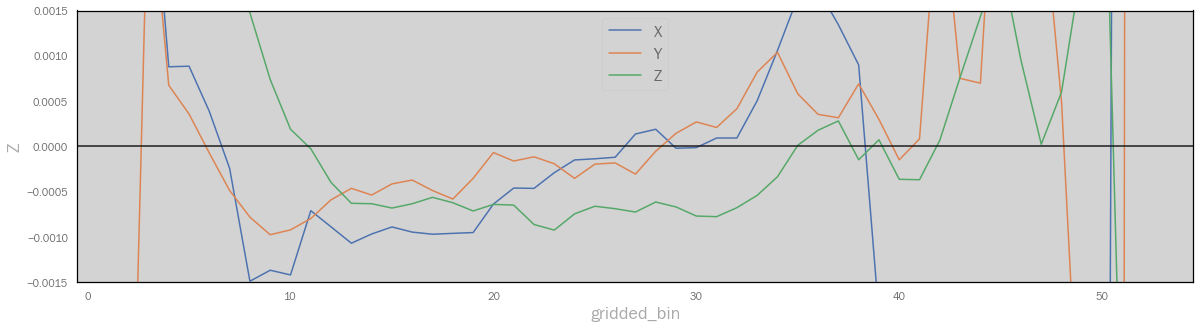

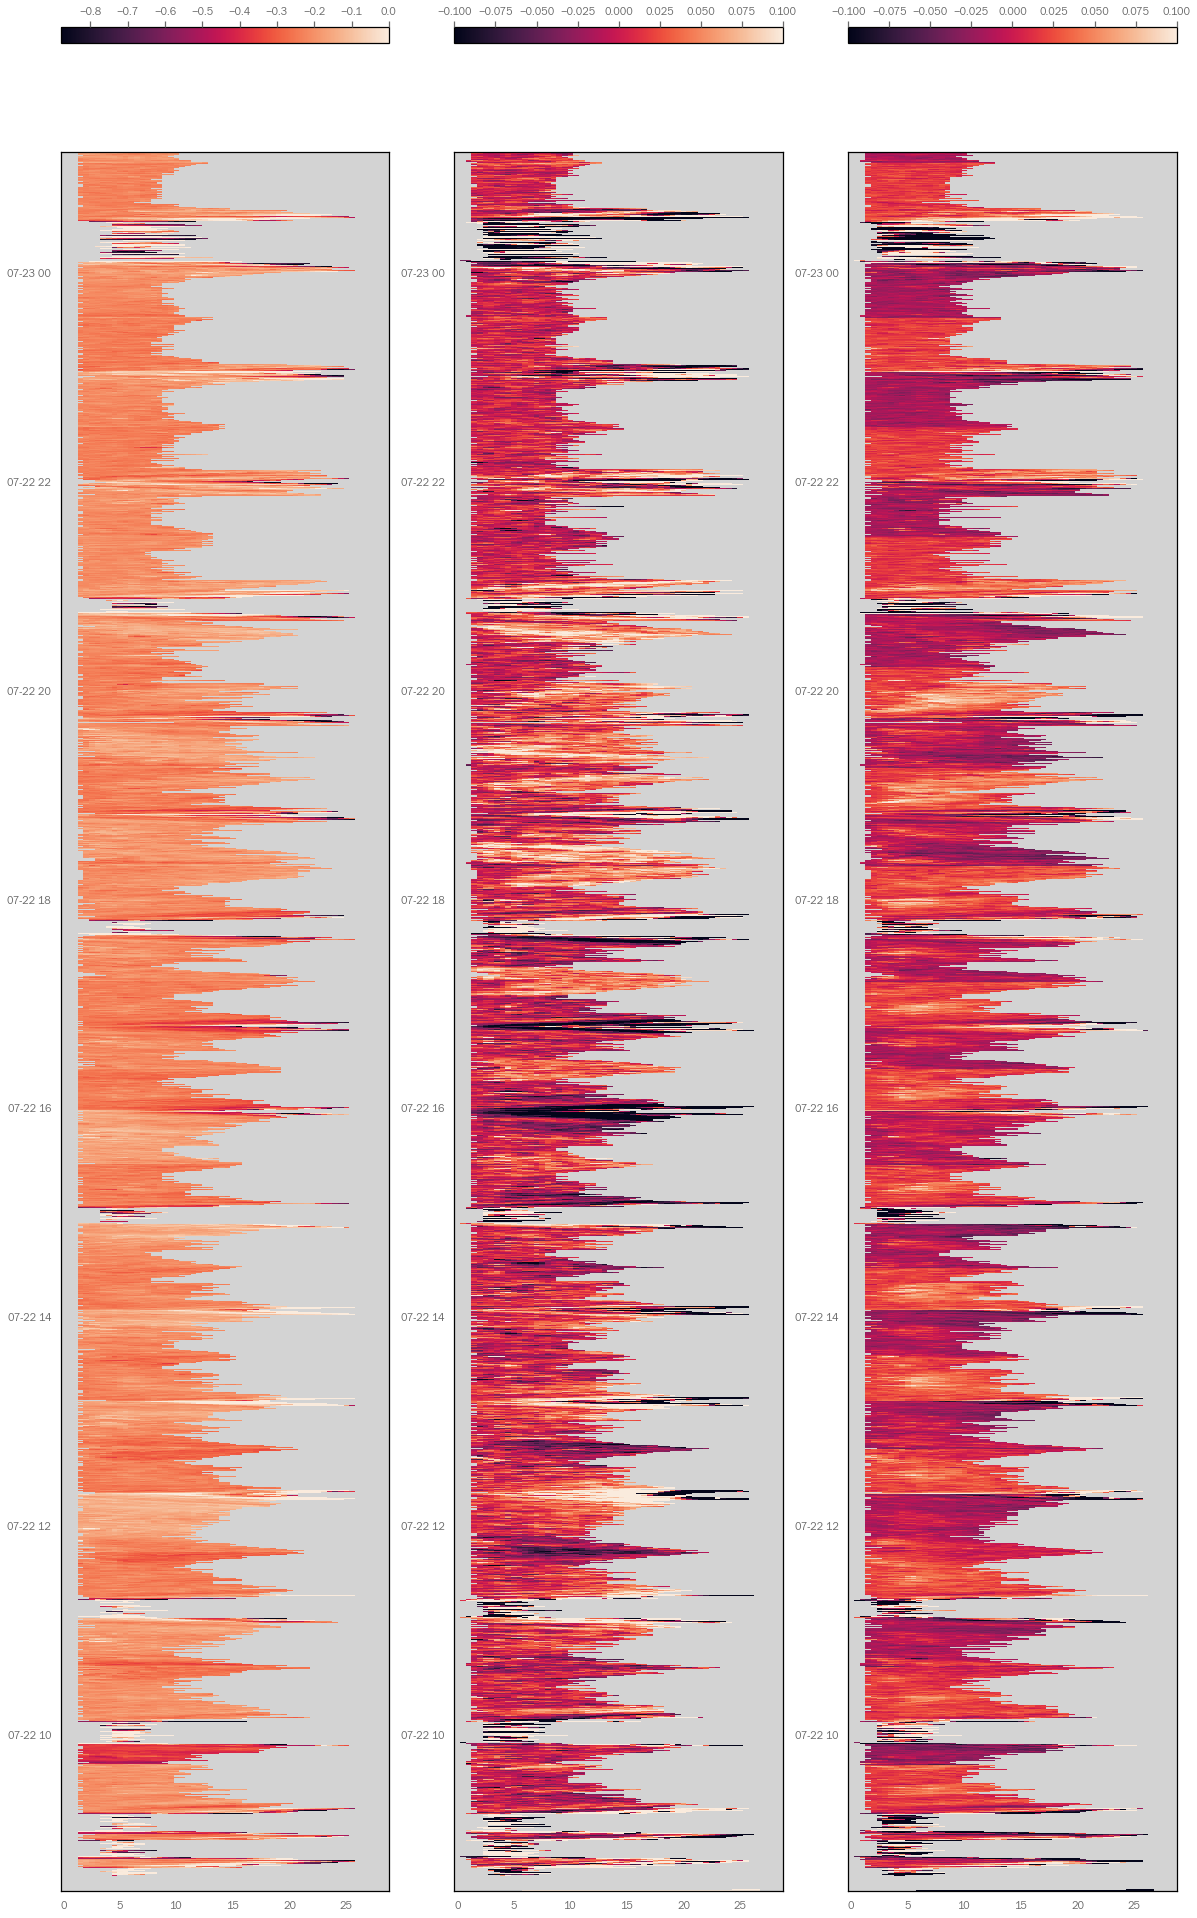

In [15]:
ADCP = process_adcp.calcXYZfrom3beam(ADCP, options)

2023-07-13 12:10:23 : Converted from XYZ to ENU


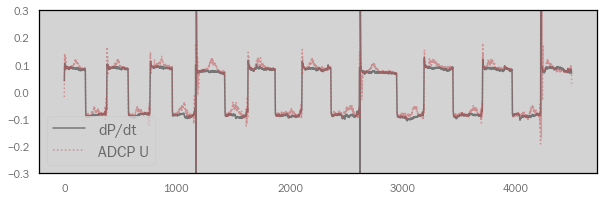

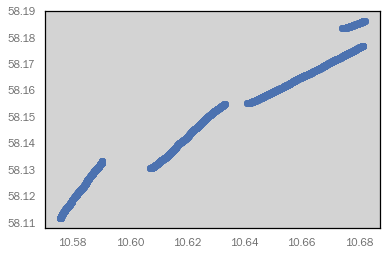

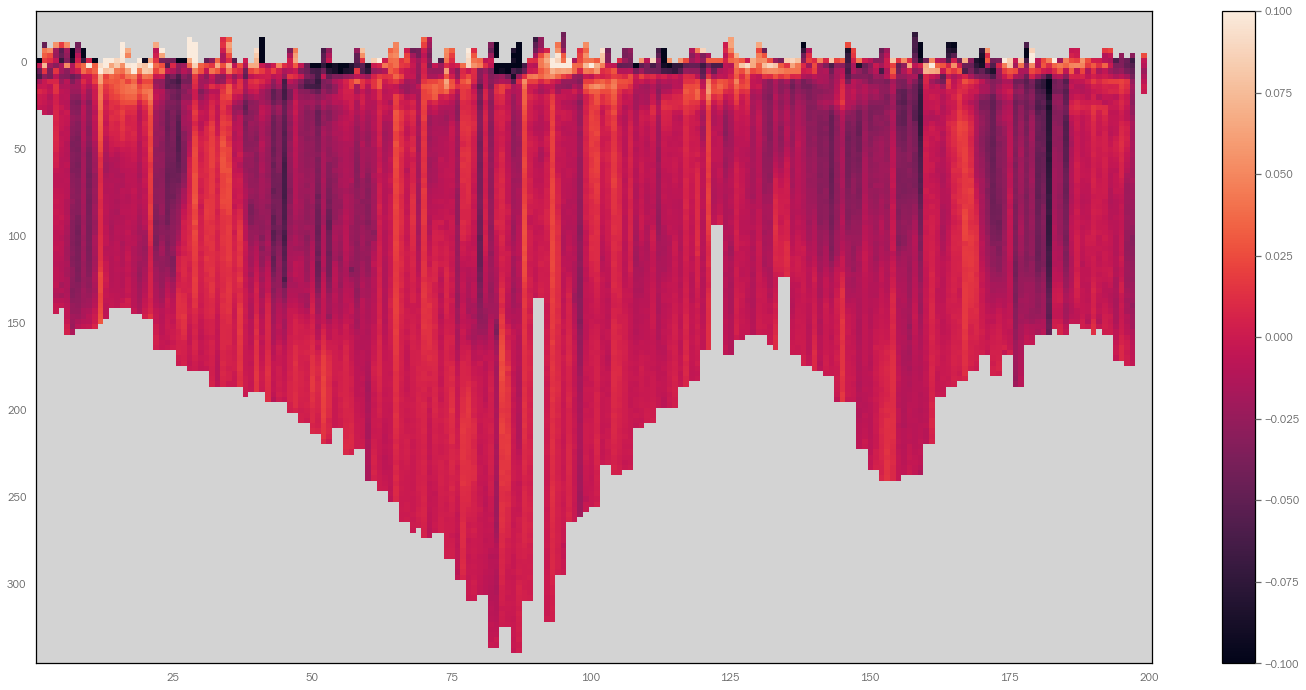

In [16]:
ADCP = process_adcp.calcENUfromXYZ(ADCP, data, options)

## Check if errors in the above are related to motor movements?

22043 21207


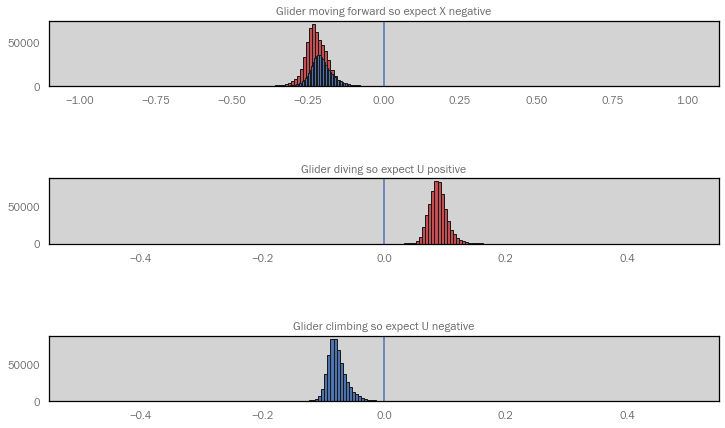

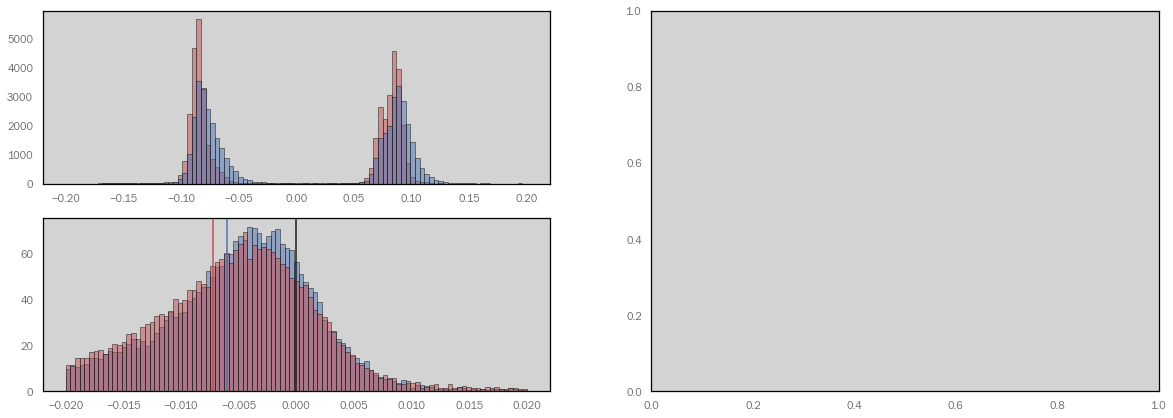

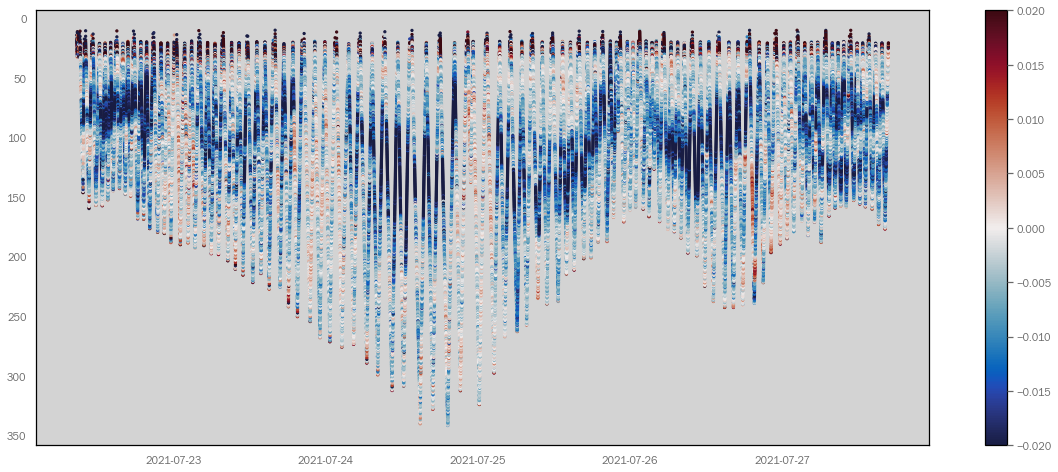

In [17]:
process_adcp.verify_calcENUfromXYZ(ADCP)

### Mismatch above sign of misalignment of ADCP / incorrect pitch/roll ?

## 3.7. Grid shear

100%|█████████████████████████████████████████████| 8/8 [00:00<00:00, 26.45it/s]


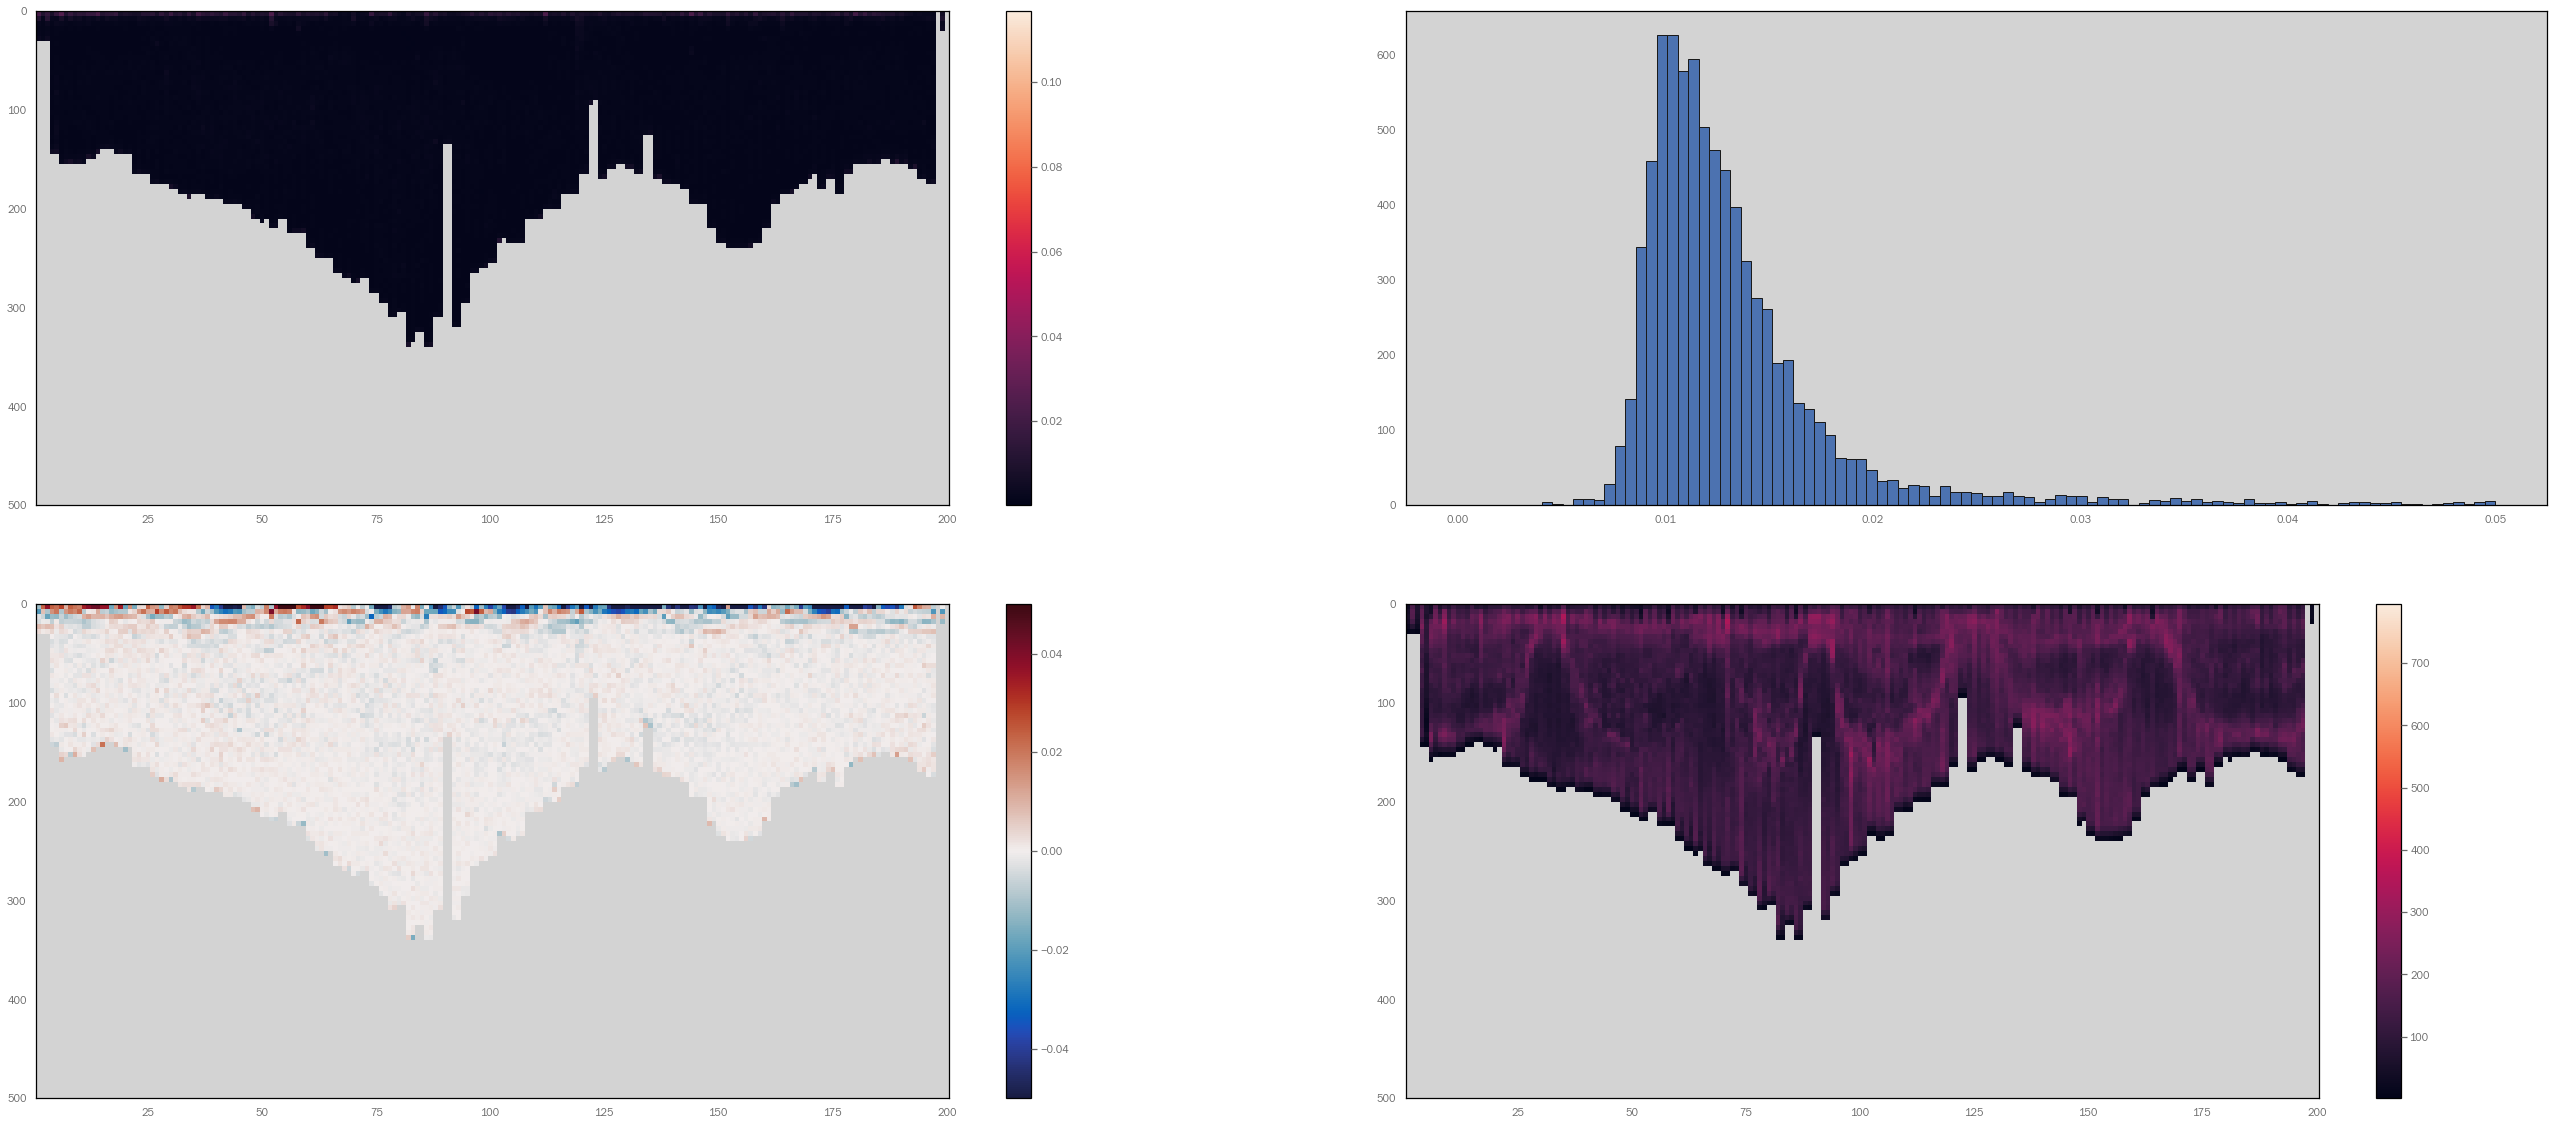

In [18]:
xaxis, yaxis, taxis, days = process_adcp.grid_shear_data(ADCP, data, options)
out = process_adcp.grid_data(ADCP, data, {}, xaxis, yaxis)
ds = process_adcp.make_dataset(out)

# Add extra variables for integrating shear

In [19]:
extra_data = pd.read_parquet(glider_pqt_path)
data["speed_vert"] = extra_data["speed_vert"]
data["speed_horz"] = extra_data["speed_horz"]
data["DeadReckoning"] = extra_data["DeadReckoning"]
data["NAV_RESOURCE"] = extra_data["NAV_RESOURCE"]
data["diveNum"] = extra_data["diveNum"]

## 5.2. Calculate dive-averaged current

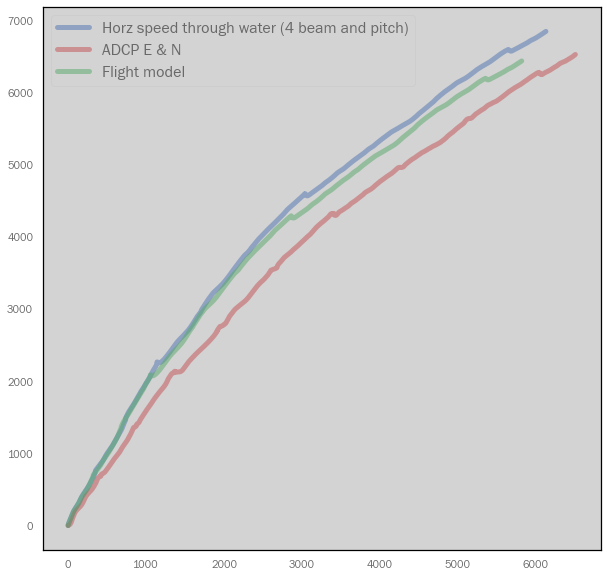

In [20]:
process_adcp.plot_subsurface_movement(ADCP, data)

No final GPS for dive 97.0


<Figure size 1080x504 with 0 Axes>

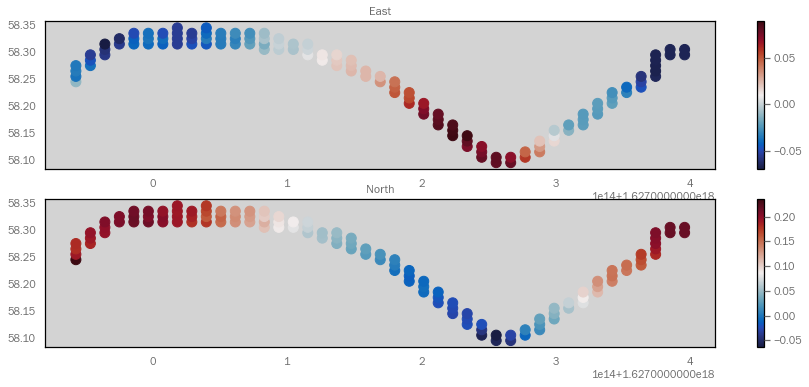

In [21]:
data = process_adcp.get_DAC(ADCP, data, options)

## 5.3. Get surface drift

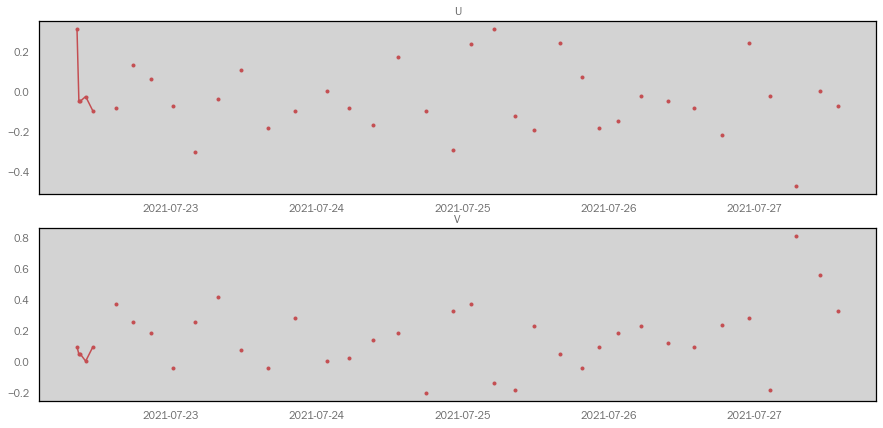

In [22]:
dE,dN,dT = process_adcp.getSurfaceDrift(data, options)

## 5.4. Get bottom track data

In [23]:
ADCP = process_adcp.bottom_track(ADCP, adcp_path, options)

100%|████████████████████████████████████| 1834/1834 [00:00<00:00, 18033.84it/s]


Profile 0 was empy
Profile 199 was empy


100%|████████████████████████████████████████| 85/85 [00:00<00:00, 31763.71it/s]


## 5.5. Reference ADCP data

/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1658: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ## PLOT 1
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1662: UserWarning: No contour levels were found within the data range.
  plt.colorbar()
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1658: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ## PLOT 1
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1662: UserWarning: No contour levels were found within t

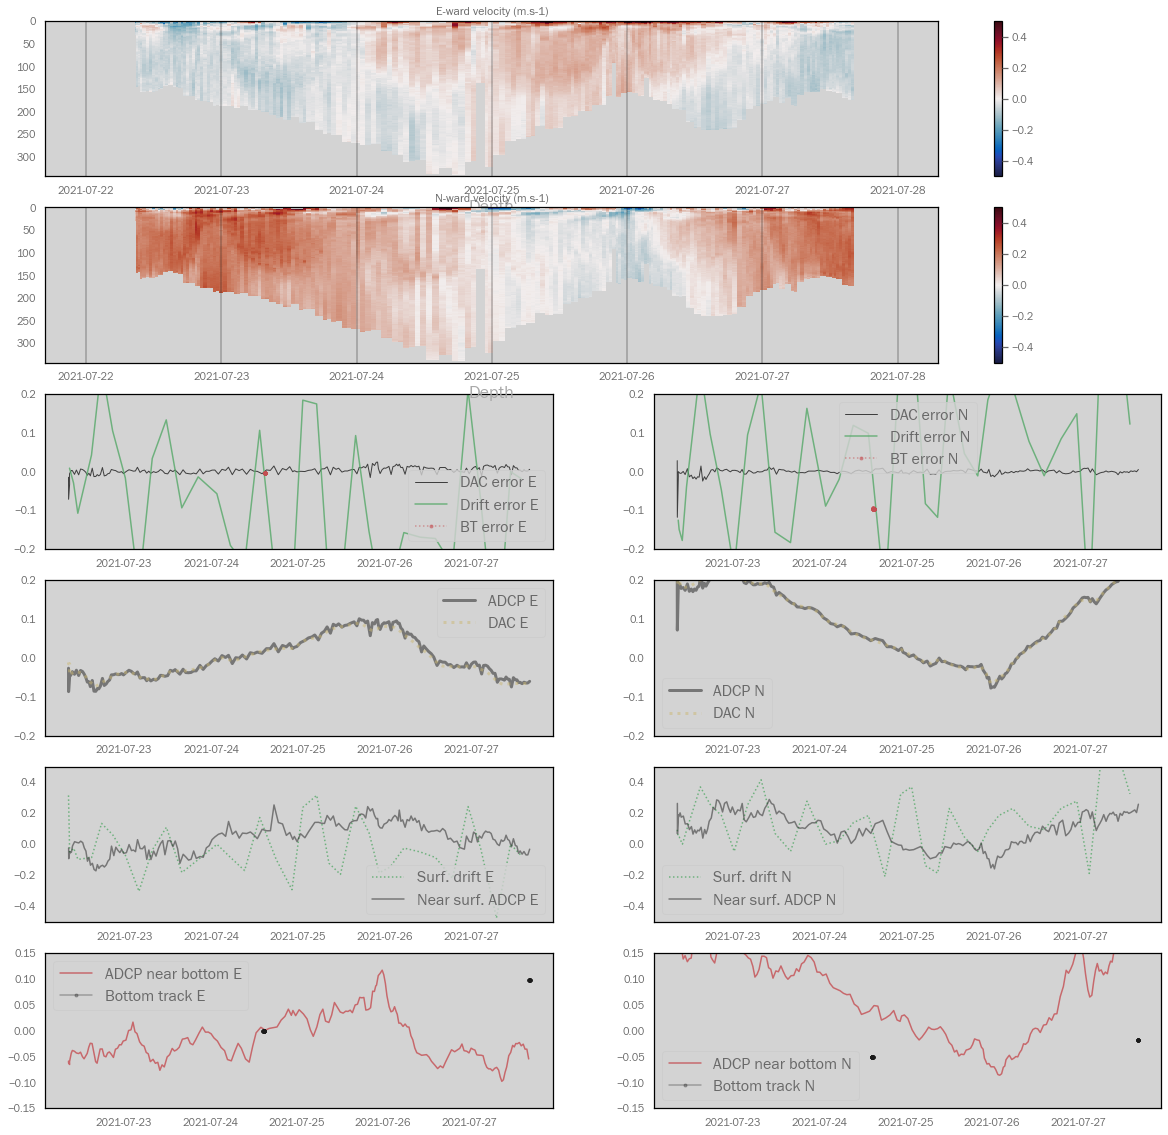

In [24]:
out = process_adcp.reference_shear(ADCP, data, dE,dN,dT, xaxis, yaxis, taxis, options)

# VI. Grid and plot data

In [25]:
out = process_adcp.grid_data(ADCP, data, out, xaxis, yaxis)

100%|███████████████████████████████████████████| 15/15 [00:00<00:00, 26.13it/s]


In [26]:
#process_adcp.verify_depth_bias(out, yaxis)

 27%|███████████                              | 27/100 [00:00<00:00, 279.91it/s]
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1796: RuntimeWarning: invalid value encountered in remainder
  south = np.gradient(out['latitude'], axis=1) < 0
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1797: RuntimeWarning: invalid value encountered in remainder
  


Optimization terminated successfully.
         Current function value: 165543.981178
         Iterations: 27
         Function evaluations: 54
(array([0.00090637]), 165543.98117795307, 27, 54, 0)


/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1933: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ## PLOT 1
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1937: UserWarning: No contour levels were found within the data range.
  plt.colorbar()
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1944: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  
/home/callum/Documents/coding/SeaExplorerTools/seaexplorertools/process_adcp.py:1948: UserWarning: No contour levels were found within the data r

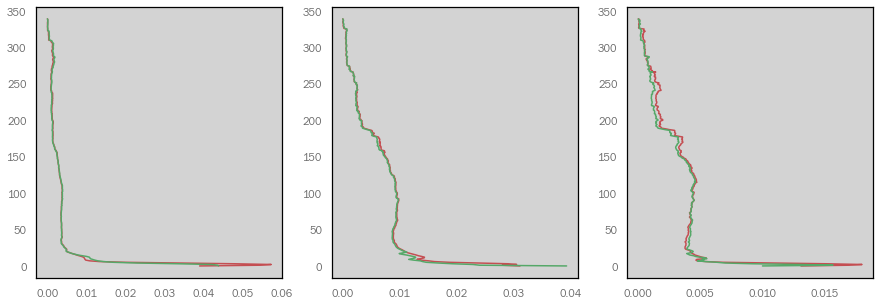

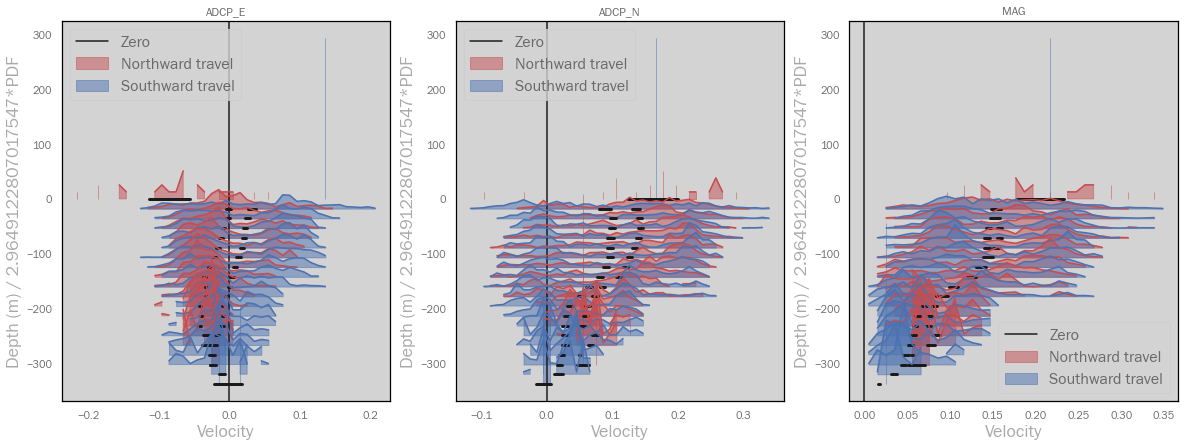

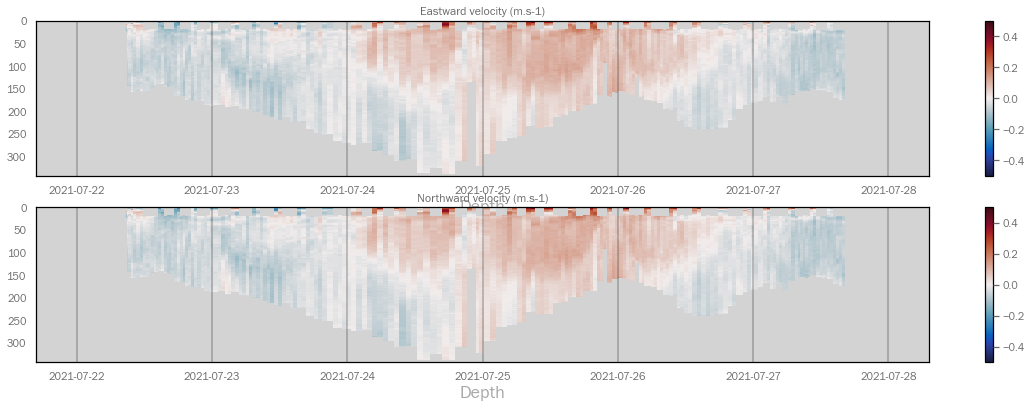

In [27]:
out = process_adcp.calc_bias(out, yaxis, taxis, days, options)

# Create xarray DataSet from `out` and compare results

In [28]:
ds = process_adcp.make_dataset(out)
ds_min = ds[['Sh_E', 'Sh_N','Sh_U', 'ADCP_E', 'ADCP_N']]

In [29]:
ds_min_test = xr.open_dataset("tests/test_files/ds_out_min.nc")

The processing chain uses some non-determinate functions that can produce small numerical differences in results, so we test with `numpy.allclose` rather than `equals`

In [30]:
for var in list(ds_min):
    assert np.allclose(ds_min[var], ds_min_test[var], equal_nan=True, atol=1e-7, rtol=1e-3)

## SHEAR BIAS NOTES AND THOUGHTS

Side lobe interference: strong fish signal in front causes apparent upwelling on downward facing ADCP because Beam 1 sees strong negative velocity component. Sidelobe in beams 2 and 4 introduces strong negative velocity. Strong negative velocity in Beam 1 2 and 4 means upwelling (or downwelling with upward facing adcp).

So what if strong 0 velocity observed in beams 2 and 4 (because orthogonal to X) means strong 0 doppler in beams 1 and 3 which introduces bias velocity measurement?